In [1]:
# [1] وارد کردن کتابخانه‌ها
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import string
import matplotlib.pyplot as plt

In [2]:
# [2] خواندن داده + چک اولیه
file_path = 'training.1600000.processed.noemoticon.csv'
column_names = ['sentiment', 'id', 'date', 'query', 'user', 'text']

try:
    temp_df = pd.read_csv(file_path, header=None, encoding='latin1', names=column_names, low_memory=False)
    print("✅ مقادیر sentiment در فایل:")
    print(temp_df['sentiment'].value_counts())

    df = temp_df.copy()
except FileNotFoundError:
    print("❌ Dataset file not found.")
    exit()
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    exit()

✅ مقادیر sentiment در فایل:
sentiment
0                     799996
4                     248576
polarity of tweet          1
Name: count, dtype: int64


In [3]:
# [3] تمیز کردن ستون sentiment
print("\n🔧 قبل از فیلتر کردن sentiment:")
print(df['sentiment'].value_counts())

df['sentiment'] = df['sentiment'].astype(str).str.strip().str.lower()
df = df[df['sentiment'].isin(['0', '4'])]

print("\n✅ بعد از فیلتر کردن sentiment (0 و 4):")
print(df['sentiment'].value_counts())

df['sentiment'] = df['sentiment'].replace({'0': 0, '4': 4})
df['sentiment'] = pd.to_numeric(df['sentiment'], errors='raise')


🔧 قبل از فیلتر کردن sentiment:
sentiment
0                     799996
4                     248576
polarity of tweet          1
Name: count, dtype: int64

✅ بعد از فیلتر کردن sentiment (0 و 4):
sentiment
0    799996
4    248576
Name: count, dtype: int64


/var/folders/c6/kh1v5smn18l3tbcsjpvvqv1h0000gn/T/ipykernel_7971/694106730.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'0': 0, '4': 4})


In [4]:
# [4] پیش‌پردازش متن
punctuation = string.punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', punctuation)
    return text.translate(translator)

df['text_lower'] = df['text'].str.lower()
df['text_without_punctuation'] = df['text_lower'].apply(remove_punctuation)

In [5]:
# [5] تقسیم داده‌ها
X = df['text_without_punctuation']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y
)

print("\n📊 توزیع کلاس‌ها در train:")
print(y_train.value_counts())

print("\n📊 توزیع کلاس‌ها در test:")
print(y_test.value_counts())


📊 توزیع کلاس‌ها در train:
sentiment
0    639996
4    198861
Name: count, dtype: int64

📊 توزیع کلاس‌ها در test:
sentiment
0    160000
4     49715
Name: count, dtype: int64


In [10]:
# [6] TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
#just fit in train and not in test because of data leakage
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\n🔢 تعداد ویژگی‌ها:", len(tfidf_vectorizer.vocabulary_))


🔢 تعداد ویژگی‌ها: 504228


In [7]:
# [7] آموزش مدل Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [8]:
# [8] ارزیابی مدل
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n🎯 دقت مدل Naive Bayes: {accuracy:.4f}")
print("\n📋 گزارش طبقه‌بندی:")
print(classification_report(y_test, y_pred))


🎯 دقت مدل Naive Bayes: 0.7781

📋 گزارش طبقه‌بندی:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87    160000
           4       0.94      0.07      0.13     49715

    accuracy                           0.78    209715
   macro avg       0.86      0.53      0.50    209715
weighted avg       0.81      0.78      0.70    209715



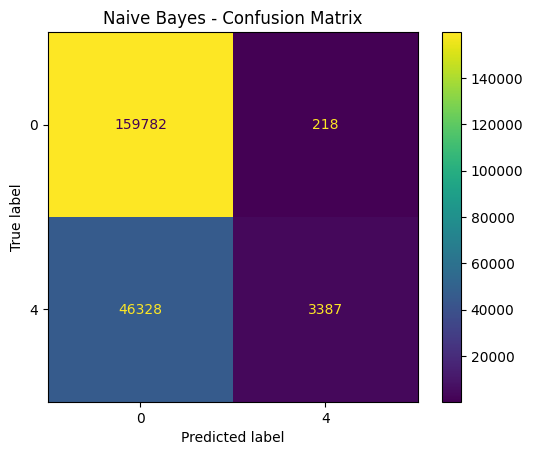

In [9]:
# [9] Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Naive Bayes - Confusion Matrix")
plt.show()

In [10]:
# [10] Cross Validation
cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("\n🔁 Cross-validation scores:", cv_scores)
print(f"میانگین دقت CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


🔁 Cross-validation scores: [0.77772215 0.7779248  0.77782215 0.77795924 0.77817978]
میانگین دقت CV: 0.7779 ± 0.0002



🎯 دقت مدل Logistic Regression: 0.8540
              precision    recall  f1-score   support

           0       0.87      0.95      0.91    160000
           4       0.76      0.56      0.65     49715

    accuracy                           0.85    209715
   macro avg       0.82      0.75      0.78    209715
weighted avg       0.85      0.85      0.85    209715



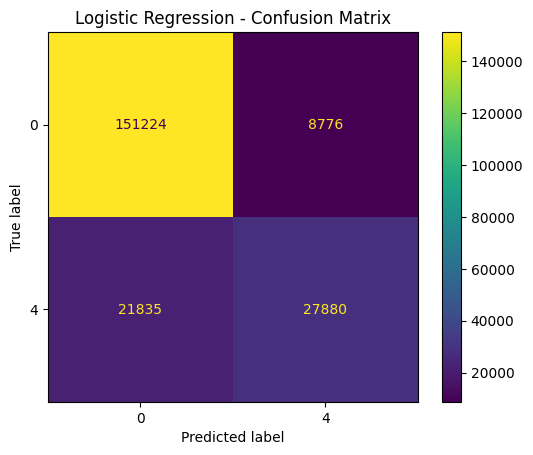

In [11]:
# [11] Optional: Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"\n🎯 دقت مدل Logistic Regression: {accuracy_lr:.4f}")
print(classification_report(y_test, y_pred_lr))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

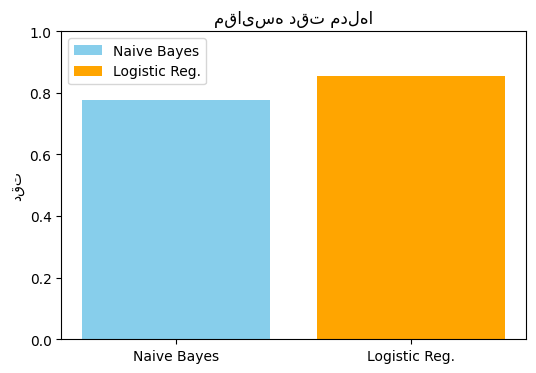

In [12]:
# [12] نمودار دقت
plt.figure(figsize=(6, 4))
plt.bar(['Naive Bayes'], [accuracy], color='skyblue', label='Naive Bayes')
plt.bar(['Logistic Reg.'], [accuracy_lr], color='orange', label='Logistic Reg.')
plt.ylabel('دقت')
plt.title('مقایسه دقت مدل‌ها')
plt.legend()
plt.ylim(0, 1)
plt.show()

<div style = "direction : rtl;">
# تحلیل احساسات نظرات توییت با استفاده از Naive Bayes

این پروژه یه مدل طبقه‌بندی ساده رو با استفاده از Naive Bayes روی داده‌های نظرات توییت آموزش داده.  
هدف: تشخیص احساسات مثبت (`4`) و منفی (`0`) در نظرات.

## مراحل انجام شده:

1. **پیش‌پردازش داده‌ها:**
   - حذف علامت‌های نگارشی (`punctuation`)
   - تقسیم داده‌ها به `train` و `test` با `stratify=y` برای حفظ تعادل کلاس‌ها

2. **استخراج ویژگی‌ها:**
   - استفاده از `TfidfVectorizer` برای تبدیل متن به بردار عددی
   - وزن‌دهی به کلمات مهم (کلماتی که توی همه جا نیستن)

3. **آموزش مدل:**
   - استفاده از `MultinomialNB` برای طبقه‌بندی
   - آموزش مدل روی داده‌های `train`

4. **ارزیابی مدل:**
   - محاسبه دقت کلی (~77%)
   - تولید گزارش طبقه‌بندی (`classification_report`) برای بررسی عملکرد روی هر کلاس
   - رسم ماتریس اشتباهات (`confusion matrix`) برای مشاهده اشتباهات
   - اجرای اعتبارسنجی متقابل (`cross-validation`) برای بررسی پایداری مدل

5. **نتایج نهایی:**
   - دقت کلی: ~77%
   - مشکل اصلی: مدل روی کلاس `4` (نظرات مثبت) ضعیف عمل کرده (Recall = 7%)

6. **پیشنهادات بهبود:**
   - استفاده از `class_weight='balanced'` برای حل عدم تعادل کلاس‌ها
   - استفاده از مدل‌های قوی‌تر مثل Logistic Regression یا SVM
   - افزایش داده‌های کلاس `4` با Oversampling
   - انجام پیش‌پردازش بیشتر (مثل حذف Stop Words یا Stemming)

## نتیجه‌گیری:
مدل Naive Bayes یه پایه خوب برای تحلیل احساسات فراهم میکنه ولی روی داده‌های نامتعادل ضعیف عمل میکنه. با بهبودهای پیشنهادی میشه عملکردش رو ارتقا داد، به‌ویژه روی کلاس کمیاب (`4`).
</div>